In [226]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel, DoG_Iso2DGaussianModel, Norm_Iso2DGaussianModel, CSenFModel
from prfpy.fit import Iso2DGaussianFitter
from prfpy.rf import gauss2D_iso_cart
import os
import yaml

from prfpy_bayes.utils import *
from prfpy_bayes.prf_bayes import *

from dag_prf_utils.prfpy_functions import *
from dag_prf_utils.plot_functions import *
from scipy import stats 
import time

import multiprocessing
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [227]:
# setup e.g. data and ts...
# Getting the correct stimuli
from amb_scripts.load_saved_info import *
from amb_scripts.utils import *


In [228]:

sub = 'sub-02'
roi_fit = 'all'
roi_mask = amb_load_roi(sub, roi_fit)
# task_list = ['CSFLE', 'CSFRE']#
task_list = ['pRFLE', 'pRFRE'] 
model = 'norm'

real_tc = {}
cprf_data = {}
settings = {}
for ses in ['1', '2']:
    real_tc[ses] = amb_load_real_tc(
        sub=sub,
        task_list=task_list,
        ses=f"ses-{ses}",    
    )
    cprf_data[ses] = amb_load_prf_params(
        sub=sub,
        task_list=task_list,
        model_list=model, 
        ses=f"ses-{ses}",    
        )    
    settings[ses] = amb_load_fit_settings(
        sub=sub,
        task_list=task_list,
        model_list=model, 
        ses=f"ses-{ses}", 
        roi_fit=roi_fit,
        )

# Setup session agnostic stuff
if model=='csf':
    prefix = 'CSF'
    prfpy_stim = amb_load_prfpy_stim(dm_type='csf')
else:
    prefix = 'pRF'
    prfpy_stim = amb_load_prfpy_stim(dm_type='prf')    



/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy/prfpy/stimulus.py:252: RuntimeWarning: divide by zero encountered in log10
  self.log_SF_seq = np.log10(SF_seq)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy/prfpy/stimulus.py:254: RuntimeWarning: divide by zero encountered in true_divide
  self.CON_S_seq = 100/CON_seq


In [260]:
# Create the multi object:
pid_list = []
obj_list = []
for ses in ['1', '2']:
    for eye in ['L', 'R']:
        # classic
        pid_list.append(f'c{eye}{ses}')
        # this_cprf = Prf1T1M(cprf_data[ses][f'{prefix}{eye}E'][model][roi_mask,:], model)
        this_cprf = Prf1T1M(cprf_data[ses][f'{prefix}{eye}E'][model], model)
        obj_list.append(this_cprf)


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:282: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_sf0'] = np.log10(self.params_dd['sf0'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:283: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_maxC'] = np.log10(self.params_dd['maxC'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:285: RuntimeWarning: divide by zero encountered in true_divide
  10**(np.sqrt(self.params_dd['log10_maxC']/(self.params_dd['width_r']**2)) + \
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:285: RuntimeWarning: invalid value encountered in sqrt
  10**(np.sqrt(self.params_dd['log10_maxC']/(self.params_dd['width_r']**2)) + \
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_ut

In [261]:
prf_all = PrfMulti(obj_list, pid_list)

# Add aulcsf
if model == 'csf':
    print('adding AULCSF')
    for prf_id in prf_all.id_list:
        this_prf_obj = []
        this_prf_obj = prf_all.prf_obj[prf_id]
        prf_all.prf_obj[prf_id].pd_params['aulcsf'] = add_aulcsf_to_obj(this_prf_obj, prfpy_stim)
        prf_all.prf_obj[prf_id].pd_params['aulcsfV2'] = add_aulcsf_to_objV2(this_prf_obj, prfpy_stim)


adding AULCSF


/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/amb_scripts/utils.py:101: RuntimeWarning: divide by zero encountered in log10
  
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/amb_scripts/utils.py:102: RuntimeWarning: divide by zero encountered in log10
  
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/amb_scripts/utils.py:103: RuntimeWarning: divide by zero encountered in log10
  
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/amb_scripts/utils.py:107: RuntimeWarning: invalid value encountered in subtract
  log_maxC = np.log10(maxC)
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/amb_scripts/utils.py:107: RuntimeWarning: invalid value encountered in multiply
  log_maxC = np.log10(maxC)
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/amb_scripts/utils.py:108: RuntimeWarn

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


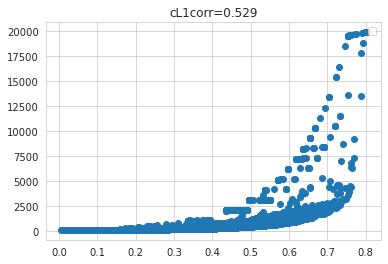

<Figure size 432x288 with 0 Axes>

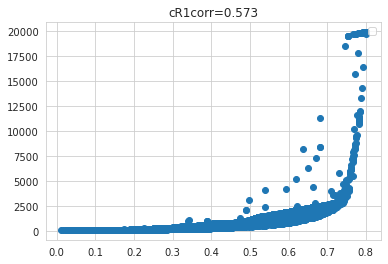

<Figure size 432x288 with 0 Axes>

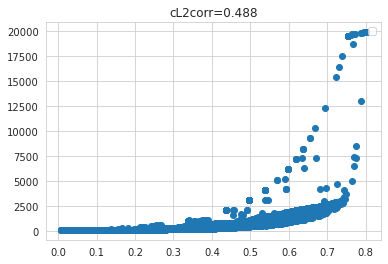

<Figure size 432x288 with 0 Axes>

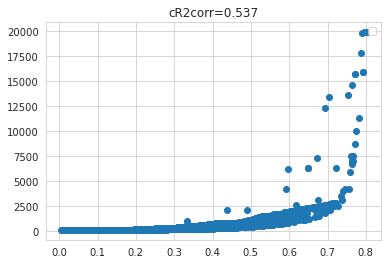

<Figure size 432x288 with 0 Axes>

In [262]:
for p in prf_all.id_list:
    plt.figure()
    plt.title(p)
    prf_all.prf_obj[p].rapid_p_corr(
        'aulcsf', 'aulcsfV2', ax=plt.gca()
        )
    plt.figure()


In [ ]:
# AULCSF testing
ivx = 1
this_prfobj = prf_all.prf_obj['cL1']
SFs = np.linspace(0,100)
logCSF = ncsf_curve(
    SFs=SFs,
    width_r = this_prfobj.pd_params['width_r'][ivx],
    sf0 = this_prfobj.pd_params['sf0'][ivx],
    maxC = this_prfobj.pd_params['maxC'][ivx],
    width_l = this_prfobj.pd_params['width_l'][ivx],
)
print(f'{ivx} aulcsf = {this_prfobj.pd_params["aulcsf"][ivx]}')
plt.plot(SFs, logCSF)
np.trapz(logCSF, SFs)

In [249]:
prf_all.add_prf_diff('cL1', 'cR1', 'diff_E1')
prf_all.add_prf_diff('cL2', 'cR2', 'diff_E2')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


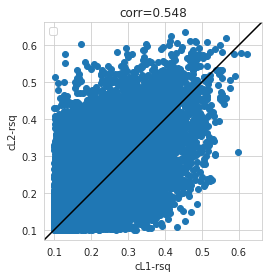

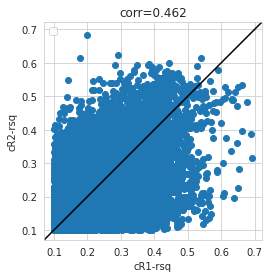

In [263]:
# check rsq
plt.figure()
prf_all.rapid_p_corr('cL1-rsq', 'cL2-rsq', do_id_line=True, do_scatter=True, do_kde=False)
plt.gca().set_aspect('equal')
plt.figure()
prf_all.rapid_p_corr('cR1-rsq', 'cR2-rsq', do_id_line=True, do_scatter=True, do_kde=False)
plt.gca().set_aspect('equal')


In [ ]:
# xlim = [0,1]
# ylim = [0,1]
# p = 'aulcsf'
# plt.figure()
# fig, ax_list = prf_all.rapid_multi_scat(
#     [f'cL1-{p}', f'cL2-{p}', f'cR1-{p}', f'cR2-{p}'],min_rsq=0.1,
#     dag_scatter=True,do_scatter=True, do_id_line=True, do_kde=False,
#     )
# for i1 in np.arange(0,4):
#     for i2 in np.arange(0,4):
#         if i2>i1:
#             ax_list[i1][i2].plot(xlim,ylim, 'k')
#             ax_list[i1][i2].set_xlim(xlim)
#             ax_list[i1][i2].set_ylim(ylim)


# fig.set_size_inches(15,15)

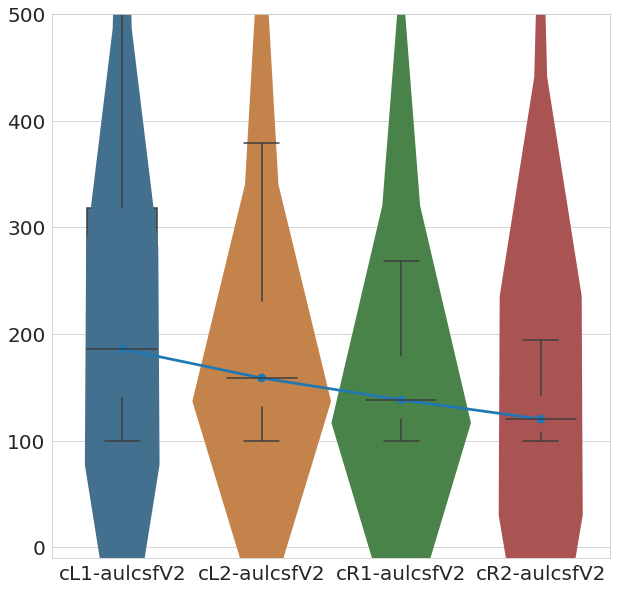

In [269]:
p = 'aulcsfV2'
f_type = 'c'
p_list = [f'{f_type}L1-{p}', f'{f_type}L2-{p}', f'{f_type}R1-{p}', f'{f_type}R2-{p}']
cond_list = [i.split('-')[0] for i in p_list]
th = {}
for this_cond in cond_list:
    th[f'{this_cond}-min-rsq'] = .1
    # th[f'{this_cond}-max-ecc'] = 5
roi_mask = amb_load_roi(sub, 'all')    
th['roi'] = roi_mask

pd2plot = pd.DataFrame(prf_all.return_th_params(p_list, th))

dag_full_violin(pd2plot)         
plt.gca().set_ylim(-10,500)
plt.gcf().set_size_inches(10,10)
dag_update_ax_fontsize(plt.gca(), 20)

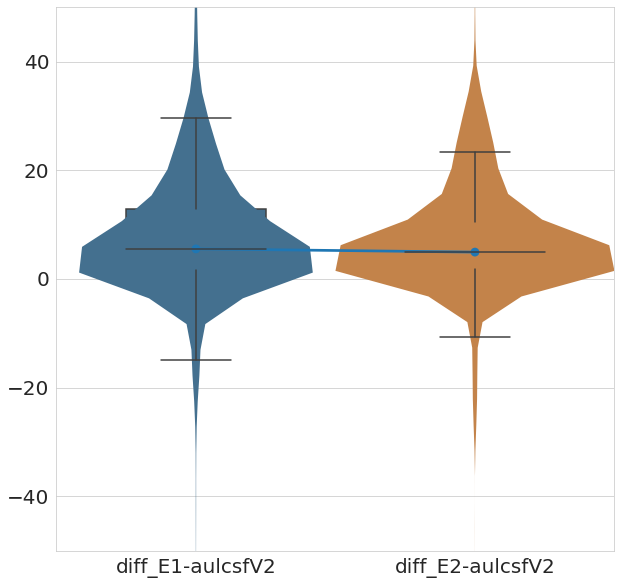

In [254]:
# diff
p = 'aulcsfV2'
f_type = 'c'
p_list = [f'diff_E1-{p}',f'diff_E2-{p}'] 

th = {}
th['all-min-rsq'] = .1
# th['all-bound-ecc'] = [0,5]
roi_mask = amb_load_roi(sub, 'all')    
th['roi'] = roi_mask

pd2plot = pd.DataFrame(prf_all.return_th_params(p_list, th))

dag_full_violin(pd2plot)         
plt.gca().set_ylim(-50,50)
plt.gcf().set_size_inches(10,10)
dag_update_ax_fontsize(plt.gca(), 20)

In [ ]:
p = 'size_1'
f_type = 'c'
task_list = ['L1', 'L2', 'R1', 'R2']
p_list = [f'{f_type}{i}-{p}' for i in task_list]
c_list = [f'{f_type}{i}' for i in task_list]
th ={}
for c in c_list:
    th[f'{c}-min-rsq'] = .1
    # th[f'{c}-bound-ecc'] = [0,2]
roi_mask = amb_load_roi(sub, ['b14_V1', 'b14_V2', 'b14_V3.'])
th['roi'] = roi_mask
pd2plot = pd.DataFrame(
    prf_all.return_th_params(p_list, th))



dag_half_violin(pd2plot, split_id=['L', 'R'], match_id=['1', '2'])    
# plt.gca().set_ylim(0,4)
plt.gcf().set_size_inches(10,10)
dag_update_ax_fontsize(plt.gca(), 20)

In [ ]:
prf_all.prf_obj['bL1'].rapid_p_corr(
    px='ecc', py='size_1', do_kde=True, dot_col='k', do_scatter=False,
)

prf_all.prf_obj['bR1'].rapid_p_corr(
    px='ecc', py='size_1', do_kde=True, dot_col='r', do_scatter=False,
    ax=plt.gca(),
)
plt.legend()
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(10,10)



plt.figure()
prf_all.prf_obj['bL2'].rapid_p_corr(
    px='ecc', py='size_1', do_kde=True, dot_col='k', do_scatter=False,
)

prf_all.prf_obj['bR2'].rapid_p_corr(
    px='ecc', py='size_1', do_kde=True, dot_col='r', do_scatter=False,
    ax=plt.gca(),
)
plt.legend()
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(10,10)





In [ ]:
prf_all.rapid_p_corr(
    px='bL1-rsq_75', 
    py='bR1-rsq_75', 
    do_kde=True, dot_col='r', do_scatter=False,
    do_id_line=True,
    # th={
    #     'bL1-min-rsq':.1,
    #     'bL2-min-rsq':.1,
    #     'bL1-bound-ecc':[0,5],
    #     'bL2-bound-ecc':[0,5],        
    # }
    # ax=plt.gca(),
)

# plt.gca().set_ylim(0,4)
# plt.gca().set_xlim(0,4)
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(10,10)

In [ ]:
prf_all.prf_obj['bL1'].pd_params.ecc_UNC

In [ ]:
p = 'x_UNC'
f_type = 'b'
p_list = [f'{f_type}L1-{p}', f'{f_type}L2-{p}', f'{f_type}R1-{p}', f'{f_type}R2-{p}']
pd2plot = pd.DataFrame(prf_all.return_th_params(p_list, min_rsq=.1))
def half_violin(pd2plot, match_id, split_id,):
    new_pd = {}
    new_pd['match_id'] = []
    new_pd['split_id'] = []
    new_pd['val'] = []
    for p in pd2plot.keys():
        pname = p.split('-')[0]
        #
        pmatch = []
        psplit = []
        if match_id[0] in pname:
            pmatch = match_id[0]
        elif match_id[1] in pname:
            pmatch = match_id[1]
        
        if split_id[0] in pname:
            psplit = match_id[0]
        elif split_id[1] in pname:
            psplit = split_id[1]

        new_pd['match_id'] += pmatch * len(pd2plot[p])
        new_pd['split_id'] += psplit * len(pd2plot[p])
        new_pd['val'] += list(pd2plot[p])
    new_pd = pd.DataFrame(new_pd)    
    sns.set_style("whitegrid")
    sns.violinplot(                                                                        
        data=new_pd, width=1, linewidth=0, inner=None,saturation=0.5,
        x='match_id', y='val', hue='split_id', split=True
        )                                     
    sns.boxplot(
        data=new_pd, showfliers = False, width=.5, saturation=0.5,
        x='match_id', y='val', hue='split_id',
        )
    sns.pointplot(
        data=new_pd, x='match_id', y='val', hue='split_id',
        estimator=np.median,
        )    
half_violin(pd2plot, split_id=['1', '2'], match_id=['L', 'R'])    
# plt.gca().set_ylim(0,5)
plt.gcf().set_size_inches(10,10)
dag_update_ax_fontsize(plt.gca(), 20)

In [ ]:
g = sns.PairGrid(pd2plot, corner=False)
g.map_upper(sns.kdeplot)

In [ ]:
penguins = sns.load_dataset("penguins")
g = sns.PairGrid(penguins)

In [ ]:
# from prf multi...


# c_all_pd = {}
# for i in ['cL1', 'cR2', 'cR1', 'cR2']:
#     c_all_pd = {**c_all_pd, **prf_all.prf_obj[i].pd_params}
# c_all_pd


# multi_pd = prf_all.return_th_param
new_pd = {}
new_pd['eye'] = []
new_pd['ses'] = []
new_pd['idx'] = []

for col in prf_all.prf_obj['cL1'].pd_params.columns:
    new_pd[col] = []

for p in ['cL1', 'cR2', 'cR1', 'cR2']:
    if 'L' in p:
        eye = 'L'
    elif 'R' in p:
        eye='R'
    if '1' in p:
        ses='1'
    elif '2' in p:
        ses = '2'
    n_entry = prf_all.prf_obj[p].pd_params.shape[0]
    new_pd['idx'] += list(np.arange(n_entry))
    new_pd['eye'] += eye * n_entry
    new_pd['ses'] += ses * n_entry
    for col in prf_all.prf_obj[p].pd_params.columns:
        new_pd[col] += list(prf_all.prf_obj[p].pd_params[col])

new_pd = pd.DataFrame(new_pd)  

In [ ]:
g = sns.PairGrid(
    data=new_pd[new_pd['ses']=='1'], 
    vars=['x', 'y', 'rsq'],   
    hue='eye', 
)
g.map(sns.scatterplot, alpha=0.1)


In [ ]:
pd2plot.iloc[:,0].mean()

# What is more similar? Eye to eye or session to session?

In [ ]:
p = 'size_1'
f_type = 'b'
p_list = [f'{f_type}L1-{p}', f'{f_type}L2-{p}', f'{f_type}R1-{p}', f'{f_type}R2-{p}']
p_th_dict = prf_all.return_th_params(p_list, min_rsq=.1)
diff_line = {}
diff_mat = np.zeros((len(p_list), len(p_list)))
for i1,k1 in enumerate(p_th_dict.keys()):    
    diff_line[k1] = []
    diff_x = []
    for i2,k2 in enumerate(p_th_dict.keys()):
        diff = np.mean((p_th_dict[k1] - p_th_dict[k2]))
        diff_line[k1].append(diff)
        diff_x.append(k2)
        diff_mat[i1,i2] = diff
        if i1>i2:
            print(f'{k1}, {k2} = {diff:.3f}')
            diff_mat[i1,i2] = diff
    if '1-' in k1:
        marker = 'o'
    else:
        marker = 'x'
    if 'L' in k1:
        col = 'g'
    else:
        col = 'r'
    plt.plot(diff_line[k1], label=k1, color=col, marker=marker)
    plt.plot((0,3), (0,0), 'k')
plt.gca().set_xticks(np.arange(len(diff_x)))
plt.gca().set_xticklabels(diff_x)
plt.legend()
#        
plt.figure()
m = plt.imshow(diff_mat, cmap='bwr',vmin=-1, vmax=1)
plt.gca().set_xticks(np.arange(len(p_list)))
plt.gca().set_xticklabels(p_list)
plt.gca().set_yticks(np.arange(len(p_list)))
plt.gca().set_yticklabels(p_list)
plt.gcf().colorbar(m, ax=plt.gca())        

In [ ]:
p = 'size_1'
f_type = 'b'
p_list = [f'{f_type}L1-{p}', f'{f_type}L2-{p}', f'{f_type}R1-{p}', f'{f_type}R2-{p}']
p_th_dict = prf_all.return_th_params(p_list, min_rsq=.1)
diff_line = {}
diff_mat = np.zeros((len(p_list), len(p_list)))
for i1,k1 in enumerate(p_th_dict.keys()):    
    diff_line[k1] = []
    diff_x = []
    for i2,k2 in enumerate(p_th_dict.keys()):
        diff = np.mean((p_th_dict[k1] - p_th_dict[k2]))
        diff_line[k1].append(diff)
        diff_x.append(k2)
        diff_mat[i1,i2] = diff
        if i1>i2:
            print(f'{k1}, {k2} = {diff:.3f}')
            diff_mat[i1,i2] = diff
    if '1-' in k1:
        marker = 'o'
    else:
        marker = 'x'
    if 'L' in k1:
        col = 'g'
    else:
        col = 'r'
    plt.plot(diff_line[k1], label=k1, color=col, marker=marker)
    plt.plot((0,3), (0,0), 'k')
plt.gca().set_xticks(np.arange(len(diff_x)))
plt.gca().set_xticklabels(diff_x)
plt.legend()
#        
plt.figure()
m = plt.imshow(diff_mat, cmap='bwr',vmin=-1, vmax=1)
plt.gca().set_xticks(np.arange(len(p_list)))
plt.gca().set_xticklabels(p_list)
plt.gca().set_yticks(np.arange(len(p_list)))
plt.gca().set_yticklabels(p_list)
plt.gcf().colorbar(m, ax=plt.gca())        

In [ ]:
prf_all.prf_obj['cL1'].pd_params.keys()

In [ ]:
ax_list

In [ ]:
ivx = 1
burn_in = 0
ivx = 1
plt.plot(samples_pvx[1]['chain'][burn_in:,:,0])
# plt.plot(samples_pvx[ivx]['log_prob'])

plt.figure()
ivx = 5
plt.plot(samples_pvx[ivx]['chain'][burn_in:, :,0])

In [ ]:
def plot_mcmcfit(ivx, real_tc, cprf_obj, bprf_obj, bprf):
    # topX best models from relevant bprf
    # topX = bprf_data[ivx]['log_prob'] >= np.percentile(bprf_data[ivx]['log_prob'], 95)    
    # max_negLL = np.where(bprf_data[ivx]['log_prob']==np.max(bprf_data[ivx]['log_prob']))[0][0]
    # ...
    n_time_points = real_tc.shape[-1]
    # Plot the true and estimated responses at different time points
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(n_time_points), real_tc[ivx,:], 'o-', label='True Response')

    print(f'BPRF {bprf_obj.prf_params_np[ivx,:]}')
    print(f'CPRF {cprf_obj.prf_params_np[ivx,:]}')
    bprf_ts = np.squeeze(bprf.prfpy_model.return_prediction(*list(bprf_obj.prf_params_np[ivx,:-1])))
    cprf_ts = np.squeeze(bprf.prfpy_model.return_prediction(*list(cprf_obj.prf_params_np[ivx,:-1])))

    print(f'B rsq = {dag_get_rsq(real_tc[ivx,:], bprf_ts):.3f}')
    print(f'C rsq = {dag_get_rsq(real_tc[ivx,:], cprf_ts):.3f}')
    # print(f'C rsq = {dag_get_rsq(real_tc[ivx,:], cprf_ts):.3f}')
    plt.plot(np.arange(n_time_points), cprf_ts, 'k-', label='Prf', lw=5)
    plt.plot(np.arange(n_time_points), bprf_ts, 'r-', label='bayes', lw=5, alpha=0.6)
    # for i in np.where(top1)[0][0:500]:
    #     plt.plot(np.arange(n_time_points), bprf.prfpy_model_wrapper(all_info['chain'][i,:]), 'r-', lw=1, alpha=0.1)
    # plt.xlabel('Time Points')
    # plt.ylabel('Response')
    # plt.legend()
    # plt.title('True and Estimated Responses over Time (Posterior Samples)')
    # plt.show()
    return None

ivx = 277
eye='R'
vx_mask = amb_load_roi(sub, 'V1_exvivo')
plot_mcmcfit(
    ivx=ivx, 
    real_tc=real_tc[f'CSF{eye}E'][vx_mask,:], 
    cprf_obj=cprf_obj[eye], 
    bprf_obj=bprf_obj[eye], 
    bprf=bprf,
    )

In [ ]:
np.where(bprf_obj['L'].return_vx_mask({'min-rsq':.5}))

In [ ]:
dir(bprf)

In [ ]:
bprf_data['CSFLE']['csf']

In [ ]:
dir(cprf_obj['L'])

In [ ]:
def incl_bestX(negLL, bestX):
    qX = np.percentile(negLL, bestX)
    incl_idx = negLL >= qX
    return incl_idx
# finite_id = np.isfinite(all_info['log_prob'])
print(this_cprf)
incl_idx = incl_bestX(all_info['log_prob'], 90)
plt.hist(all_info['chain'][incl_idx,8])
# plt.figure()
# plt.scatter(all_info['chain'][incl_idx,2], all_info['chain'][incl_idx,3])
# plt.figure()
# plt.scatter(all_info['chain'][incl_idx,2], all_info['chain'][incl_idx,4])

plt.figure()
plt.scatter(all_info['chain'][incl_idx,6], all_info['chain'][incl_idx,5])